In [1]:
import chemfit
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Setup and minimal demo

This notebook provides a minimal example of setting up and using **chemfit**. In this notebook, we will:

* Configure **chemfit** to run on the local machine
* Generate a simulated observation of a star
* Fit a spectral model to the simulated observation in order to determine the stellar parameters of the star ($T_\mathrm{eff}$, $\log(g)$, $[\mathrm{M/H}]$, $[\mathrm{\alpha/M}]$, $[\mathrm{C/M}]$)

## Model grid

**chemfit** determines stellar parameters by fitting a linearly interpolated regular grid of spectral models to the observed spectrum. The package supports multiple model grid formats. In this tutorial we will use the **pfsgrid** model grid, calculated for Main Sequence and giant stars using **chemfit**'s built-in **RESCALC** utility. **pfsgrid** can be downloaded from Google Drive: *[link to be provided]*. The drive contains three directories:

1. `fullres` is the model grid in its native resolution, $\lambda/\Delta\lambda=300,000$ ($\Delta\lambda$ is the interval between adjacent wavelength points). This grid requires a large amount of disk space ($\sim1\ \mathrm{TB}$ compressed) and is only necessary for analysis of high-resolution spectra.
2. `binned` is a 10x-binned version of the grid. I.e., each group of 10 successive wavelength points have been averaged into one, reducing the effective resolution to $\lambda/\Delta\lambda=30,000$. This grid is appropriate for low- and medium-resolution data.
3. `structures` contains the atmospheric structures of each model in the grid, which are required in the *live synthesis* mode. The *live synthesis* mode is covered in a separate tutorial.

This tutorial requires the *binned* directory to be downloaded and made accessible in your Python environment. The directory contains 4830 ZIP archives (e.g., `z0.3_a1.2_cd.zip`), each of which contains a number of `*.pkl` model files. You may extract these ZIP files for faster performance, or keep them as they are and allow **chemfit** to carry out extraction at runtime.

If you choose to extract the files, create or edit the local settings file `<chemfit directory>/settings/local/rescalc.py` to contain the following:

```python
settings = {
    'griddir': '<path to model grid>',
}
```

Here `<path to model grid>` is the location of extracted grid model files. This directory will be scanned recursively at first run. For this reason, the first initialization of **chemfit** may take some time.

If you choose to leave the model grid compressed, edit the settings file to contain the following instead:

```python
settings = {
    'griddir': '<path to model grid>',
    'model_index_file': '<path to index_binned.pkl>',
}
```

where `<path to model grid>` is the path to the directory that contains the downloaded ZIP files, and `<path to index_binned.pkl>` is the full path to the `index_binned.pkl` index file that is available in the same Google Drive.

If the model grid is set up correctly, it should be possible to initialize **chemfit** as follows:

In [2]:
chemfit.initialize('rescalc')

Once the model grid has been initialized, we can display the grid points along each axis (`zscale` is $[\mathrm{M/H}]$, `alpha` is $[\mathrm{\alpha/M}]$ and `carbon` is $[\mathrm{C/M}]$):

In [3]:
chemfit.read_grid_dimensions()

{'teff': array([3500., 3600., 3700., 3800., 3900., 4000., 4100., 4200., 4300.,
        4400., 4500., 4600., 4700., 4800., 4900., 5000., 5100., 5200.,
        5300., 5400., 5500., 5600., 5800., 6000., 6200., 6400., 6600.,
        6800., 7000., 7200., 7400., 7600., 7800., 8000.]),
 'logg': array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 'zscale': array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
        -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9,
        -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8,
        -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,
         0.4,  0.5]),
 'alpha': array([-0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,
         0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2]),
 'carbon': array([-0.4, -0.2,  0. ,  0.2,  0.4])}

Note that while $[\mathrm{M/H}]$ and $[\mathrm{\alpha/M}]$ are defined with respect to solar abundances, $[\mathrm{C/M}]$ is defined with respect to the median carbon abundance for stars of the chosen metallicity and surface gravity according to [Placco+2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...797...21P/abstract).

## Simulated observation

We will now proceed to simulate an observation. First, we must define the parameters of the spectrograph. In this minimal example, we consider a spectrograph with two arms (medium-resolution red arm and low-resolution blue arm) and provide **chemfit** with the average FWHM of their line spread functions:

In [4]:
chemfit.settings['arms'] = {
    'blue': {'FWHM': 2.1},     # Gaussian FWHM in A
    'red':  {'FWHM': 1.4},
}

The model grid can be interpolated to the required stellar parameters using the `chemfit.ModelGridInterpolator()` class. For example, the code below generates a model spectrum of a star with $T_\mathrm{eff}=4000\ \mathrm{K}$, $\log(g)=1.5$, $[\mathrm{M/H}]=-1.5$, $[\mathrm{\alpha/M}]=0.2$ and $[\mathrm{C/M}]=0.2$. In addition to the five stellar parameters, the interpolator object also requires the radial velocity (`redshift`) of the star in $\mathrm{km/s}$ (here we set it to $50$) and the linear RV correction term (`redshift_correction`), which we set to $0$ in this example. The correction term allows RV to vary as a function of wavelength to accommodate spectra with imperfect wavelength calibration.

Text(0, 0.5, 'Specific intensity [erg / s / cm^2 / A / sr]')

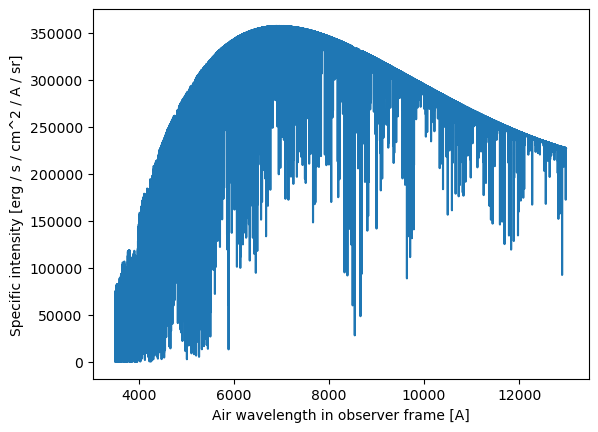

In [5]:
params = {'teff': 4000, 'logg': 1.5, 'zscale': -1.5, 'alpha': 0.2, 'carbon': 0.2,
          'redshift': 50, 'redshift_correction': 0.0}

# resample = False means "native resolution of the model"
interpolator = chemfit.ModelGridInterpolator(resample = False)
model_wl, model_flux = interpolator(params)

# Plot the result
plt.plot(model_wl, model_flux)
plt.xlabel('Air wavelength in observer frame [A]')
plt.ylabel('Specific intensity [erg / s / cm^2 / A / sr]')

We will now simulate an observation of the above spectrum with the spectrograph.

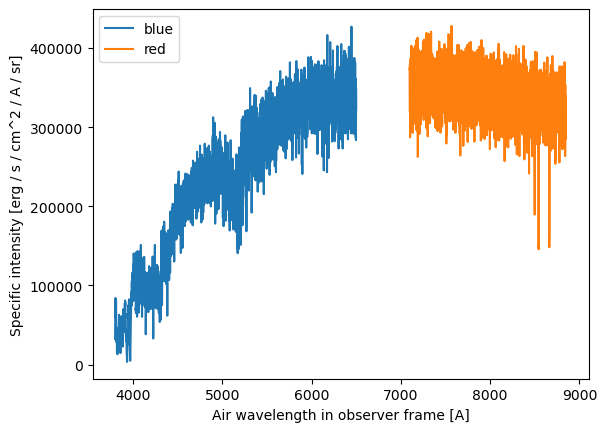

In [6]:
# Wavelength binning of the spectrograph (in A)
detector_wl = {
    'blue': np.linspace(3800, 6500, 4096),
    'red': np.linspace(7100, 8850, 4096),
}

# Generate a resampled/rebinned spectrum (combine = False means "keep the arms separated, do not merge")
observed_wl, observed_flux = chemfit.simulate_observation(model_wl, model_flux, combine = False,
                                                          detector_wl = detector_wl)

# Add Gaussian noise according to a fixed SNR
SNR = 15           # Choose the SNR
observed_ivar = {} # Inverted variances for each arm
for arm in observed_flux:
    sigma = observed_flux[arm] / SNR
    observed_ivar[arm] = sigma ** -2.0
    observed_flux[arm] = np.random.normal(observed_flux[arm], sigma)

# Plot the result
for arm in observed_wl:
    plt.plot(observed_wl[arm], observed_flux[arm], label = arm)
plt.xlabel('Air wavelength in observer frame [A]')
plt.ylabel('Specific intensity [erg / s / cm^2 / A / sr]')
plt.legend()

## Model fitting

Finally, use **chemfit** to determine the stellar parameters of the star based on the simulated observation generated above. First, we will carry out the fit using *gradient descent*.

In [7]:
# Initial guesses for the fitter
initial = {'teff': 5000, 'logg': 3.0, 'zscale': -1.0, 'alpha': 0.0, 'carbon': 0.0}

# Run the fit
fit = chemfit.chemfit(observed_wl, observed_flux, observed_ivar, initial, method = 'gradient_descent')

# Print the best-fit parameters and errors
for param in fit['fit']:
    if param in fit['errors']:
        print('{}: {:.3f}±{:.3f}'.format(param, fit['fit'][param], fit['errors'][param]))
    else:
        print('{}: {:.3f} [assumed value, did not fit]'.format(param, fit['fit'][param]))

teff: 3963.252±24.203
logg: 1.427±0.087
zscale: -1.561±0.040
alpha: 0.169±0.030
carbon: 0.164±0.049
redshift: 50.281±0.970
redshift_correction: 0.000 [assumed value, did not fit]


In a similar way, it is possible to run this fit using *MCMC* instead of *gradient descent*:

<div class="alert alert-warning">
    To use the MCMC fitter, the <a href="https://emcee.readthedocs.io/en/stable/">emcee</a> Python module must be available in your Python environment. If you chose to keep the model grid compressed, the cell below may take a considerable amount of time to run.
</div>

In [8]:
# For MCMC, configure the number of walkers, steps, and burn-in
chemfit.settings['mcmc']['nwalkers'] = 12
chemfit.settings['mcmc']['nsteps'] = 1000
chemfit.settings['mcmc']['discard'] = 200

# Initial guesses for the fitter. In the MCMC mode, the fitter will first run a gradient descent regression
# using these initial parameters, just as in the example above. It will then use the estimated best-fit
# parameters and their uncertainties to generate the initial walker positions
initial = {'teff': 5000, 'logg': 3.0, 'zscale': -1.0, 'alpha': 0.0, 'carbon': 0.0}

# Run the fit
fit = chemfit.chemfit(observed_wl, observed_flux, observed_ivar, initial, method = 'mcmc')

# Print the best-fit parameters and errors
for param in fit['fit']:
    if param in fit['errors']:
        print('{}: {:.3f}±{:.3f}'.format(param, fit['fit'][param], fit['errors'][param]))
    else:
        print('{}: {:.3f} [assumed value, did not fit]'.format(param, fit['fit'][param]))

100%|███████████████████████████████████████| 1000/1000 [28:20<00:00,  1.70s/it]

teff: 3968.758±22.354
logg: 1.444±0.078
zscale: -1.556±0.037
alpha: 0.172±0.027
carbon: 0.158±0.049
redshift: 50.082±0.970
redshift_correction: 0.000 [assumed value, did not fit]


Note that the best-fit parameters and their errors displayed above are extracted from the MCMC chains by taking the simple mean and standard deviation of the walker positions after the burn-in period. We can view the full posteriors of all parameters using the **corner** module:

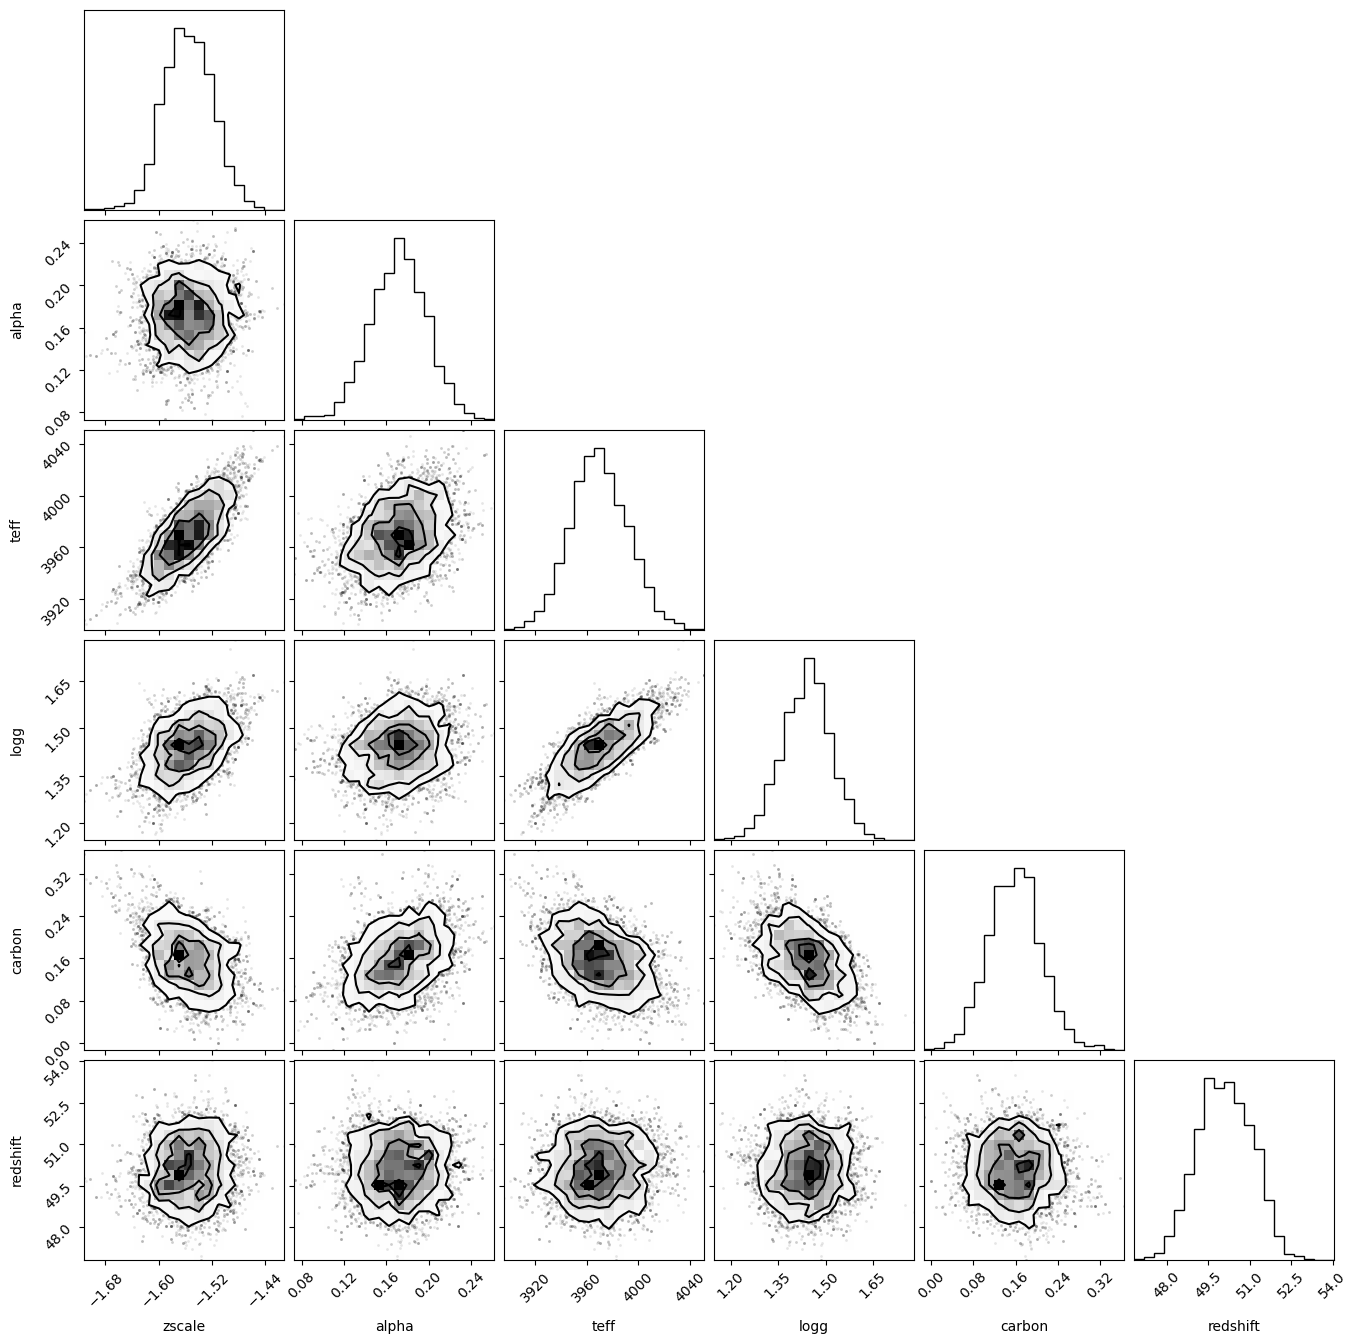

In [9]:
import corner

# Remove the burn-in steps from the chain
chain = fit['extra']['chain'][chemfit.settings['mcmc']['discard']:,:,:]

# Flatten the chain
flatchain = chain.reshape(chain.shape[0] * chain.shape[1], -1)

# Produce a corner plot
fig = corner.corner(flatchain, labels = chemfit.settings['fit_dof']);

Finally, let's over-plot the simulated observation and the best-fit model spectrum to visually inspect the goodness of fit.

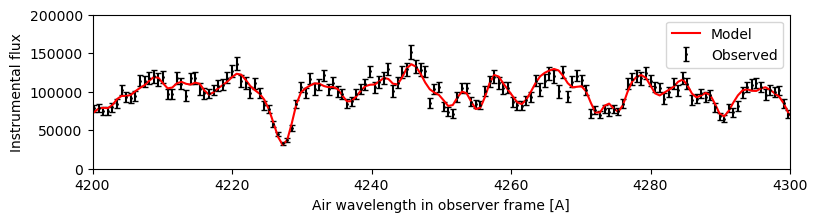

In [18]:
plt.figure(figsize = [9, 2])

# Plot the observed spectrum with errorbars
plt.errorbar(fit['extra']['observed']['wl'], fit['extra']['observed']['flux'],
             yerr = fit['extra']['observed']['ivar'] ** -0.5, fmt = 'k.',
             ms = 2, capsize = 2, label = 'Observed')

# Plot the best-fit model spectrum (['cont'] is the continuum normalization)
plt.plot(fit['extra']['model']['wl'], fit['extra']['model']['cont'] * fit['extra']['model']['flux'],
         'r-', label = 'Model')

# Zoom in near the 422 nm Ca I line
plt.xlim(4200, 4300)
plt.ylim(0, 2e5)

plt.xlabel('Air wavelength in observer frame [A]')
plt.ylabel('Instrumental flux')
plt.legend()